# Example of best-practices for running TC-Python calculations in Juypter Lab / Notebooks

This example shows how you create a single equilibrium calculation from a ternary system, loop it
while changing Al and Cr concentration, then calculate the density and plot the result as a 3D surface.   

In [1]:
# inline plotting
%matplotlib inline

# reload changed imported modules automatically
%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tc_python import *

In Jupyter lab / notebooks, the engine should be managed manually in order, to be able to use multiple cells. Remember to call these functions **exactly once**.

In [2]:
start_api_server()

13:43:37,877 [Thread-2]  INFO CalculationEngine: Starting Thermo-Calc 2019b, Java-version: 1.8.0_152


In [3]:
def plot_3d(list_of_x, list_of_y, list_of_z, xlabel, ylabel, zlabel, title):
    """
    Plot a 3d figure using matplotlib given data and labels on the three axes.

    Args:
        list_of_x: data for the x-axis
        list_of_y: data for the y-axis
        list_of_z: data for the z-axis
        xlabel: label for the x-axis
        ylabel: label for the y-axis
        zlabel: label for the z-axis
        title: title of the figure
    """
    fig = plt.figure()
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = fig.add_subplot(projection='3d')
    z = np.empty([len(list_of_x), len(list_of_y)])
    k = 0
    for index_x, x in enumerate(list_of_x):
        for index_y, y in enumerate(list_of_y):
            z[index_x, index_y] = list_of_z[k]
            k = k + 1

    xx, yy = np.meshgrid(list_of_x, list_of_y, indexing='ij')
    ax.plot_surface(xx, yy, z, cmap=cm.coolwarm, linewidth=1, antialiased=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

In [4]:
# create and configure a single equilibrium calculation
calculation = (
    SetUp()  # use this if you manually manage the engine
        .select_database_and_elements("NIDEMO", ["Ni", "Al", "Cr"])
        .get_system()
        .with_single_equilibrium_calculation()
        .set_condition(ThermodynamicQuantity.temperature(), 800)
        .set_condition(ThermodynamicQuantity.mole_fraction_of_a_component("Al"), 1E-2)
        .set_condition(ThermodynamicQuantity.mole_fraction_of_a_component("Cr"), 1E-2)
        .disable_global_minimization()
)

list_of_x_Al = np.linspace(1e-4, 10e-2, 10)
list_of_x_Cr = np.linspace(1e-4, 15e-2, 10)
list_of_density = []
for x_Al in list_of_x_Al:
    for x_Cr in list_of_x_Cr:
        calc_result = (calculation
                       .set_condition(ThermodynamicQuantity.mole_fraction_of_a_component("Al"), x_Al)
                       .set_condition(ThermodynamicQuantity.mole_fraction_of_a_component("Cr"), x_Cr)
                       .calculate()
                       )

        mass = calc_result.get_value_of('BM')
        volume = calc_result.get_value_of('VM')
        density = 1e-3 * mass / volume
        list_of_density.append(density)
        print("X(Al)={0:.2f}".format(x_Al) + " , X(Cr)={0:.2f}".format(x_Cr) + ", Density = {0:.2f}".format(
            density) + "[kg/m3]")

13:43:42,308 [Thread-2]  INFO JavaWrapper: *** Invoking Gibbs Energy System v6 ***
13:43:42,371 [Thread-2]  INFO SystemStateImpl: Verified the system state for 1 database(s) in 8 ms
13:43:43,011 [Thread-2]  INFO CalculationEngine:  Creating a new composition set BCC_B2#2
13:43:43,011 [Thread-2]  INFO CalculationEngine: New CS: BCC_B2#2
13:43:43,011 [Thread-2]  INFO CalculationEngine: New CS: BCC_A2#2
13:43:43,011 [Thread-2]  INFO CalculationEngine:  Creating a new composition set FCC_L12#2
13:43:43,011 [Thread-2]  INFO CalculationEngine: New CS: FCC_L12#2
13:43:43,011 [Thread-2]  INFO CalculationEngine: New CS: FCC_A1#2
13:43:43,120 [Thread-2]  INFO CalculationEngine:    'Thermo-calc Software AB, Ni-base DEMO (2016)'
13:43:45,714 [Thread-2]  INFO SystemStateImpl: Verified the system state for 1 database(s) in 1 ms
X(Al)=0.00 , X(Cr)=0.00, Density = 8699.08[kg/m3]
X(Al)=0.00 , X(Cr)=0.02, Density = 8667.68[kg/m3]
X(Al)=0.00 , X(Cr)=0.03, Density = 8636.58[kg/m3]
X(Al)=0.00 , X(Cr)=0.05,

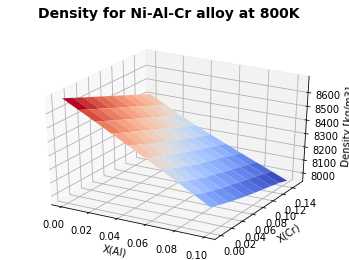

In [5]:
plot_3d(list_of_x_Al, list_of_x_Cr, list_of_density, 'X(Al)', 'X(Cr)', 'Density [kg/m3]', "Density for Ni-Al-Cr alloy at 800K")

Remember to shutdown the engine once you are done. This releases the temporary files generated - which can be of substantial size.

In [6]:
stop_api_server()